In [72]:
#Imports
import pandas as pd
import csv
from api_key import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [2]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [3]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop"
                                ]]
reduced_traffic_df.dtypes

Start_Time            object
End_Time              object
Severity               int64
City                  object
State                 object
Weather_Condition     object
Temperature(F)       float64
Visibility(mi)       float64
Wind_Speed(mph)      float64
Precipitation(in)    float64
Sunrise_Sunset        object
Description           object
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
dtype: object

In [23]:
#Using function to pars
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [34]:
reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)
reduced_traffic_df.head()

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_31259/3816699921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)


,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,Start_Year,End_Date
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,False,False,False,False,False,False,False,2016-02-08,2016,2016-02-08
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,37.9,10.0,NaN,0.00,...,False,False,False,False,False,False,False,2016-02-08,2016,2016-02-08
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,36.0,10.0,3.5,NaN,...,False,False,False,False,False,True,False,2016-02-08,2016,2016-02-08
3,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,False,False,False,False,False,False,False,2016-02-08,2016,2016-02-08
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,False,False,False,False,False,True,False,2016-02-08,2016,2016-02-08


In [30]:
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [79]:
reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)
reduced_traffic_df

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,Start_Year,End_Date,End_Year
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,False,False,False,False,False,False,2016-02-08,2016,2016-02-08,2016
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,37.9,10.0,NaN,0.00,...,False,False,False,False,False,False,2016-02-08,2016,2016-02-08,2016
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,36.0,10.0,3.5,NaN,...,False,False,False,False,True,False,2016-02-08,2016,2016-02-08,2016
3,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,False,False,False,False,False,False,2016-02-08,2016,2016-02-08,2016
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,False,False,False,False,True,False,2016-02-08,2016,2016-02-08,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2019-08-23 18:03:25,2019-08-23 18:32:01,2,Riverside,CA,Fair,86.0,10.0,13.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019,2019-08-23,2019
7728390,2019-08-23 19:11:30,2019-08-23 19:38:23,2,San Diego,CA,Fair,70.0,10.0,6.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019,2019-08-23,2019
7728391,2019-08-23 19:00:21,2019-08-23 19:28:49,2,Orange,CA,Partly Cloudy,73.0,10.0,10.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019,2019-08-23,2019
7728392,2019-08-23 19:00:21,2019-08-23 19:29:42,2,Culver City,CA,Fair,71.0,10.0,8.0,0.00,...,False,False,False,False,False,False,2019-08-23,2019,2019-08-23,2019


In [82]:
reduced_traffic_df.count()

Start_Time           7728394
End_Time             7728394
Severity             7728394
City                 7728141
State                7728394
Weather_Condition    7554935
Temperature(F)       7564541
Visibility(mi)       7551296
Wind_Speed(mph)      7157161
Precipitation(in)    5524808
Sunrise_Sunset       7705148
Description          7728389
Bump                 7728394
Crossing             7728394
Give_Way             7728394
Junction             7728394
No_Exit              7728394
Railway              7728394
Roundabout           7728394
Station              7728394
Stop                 7728394
Traffic_Calming      7728394
Traffic_Signal       7728394
Turning_Loop         7728394
Start_Date           7728394
Start_Year           7728394
End_Date             7728394
End_Year             7728394
dtype: int64

In [87]:
reduced_traffic_df[reduced_traffic_df["City"].isna()]

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,Start_Year,End_Date,End_Year
85968,2016-08-02 18:18:02,2016-08-02 19:03:02,2,NaN,CA,Clear,94.6,10.0,15.0,NaN,...,False,False,False,False,False,False,2016-08-02,2016,2016-08-02,2016
111080,2016-06-01 10:26:08,2016-06-01 11:10:00,2,NaN,CA,Partly Cloudy,91.0,10.0,5.8,NaN,...,False,False,False,False,False,False,2016-06-01,2016,2016-06-01,2016
119772,2016-12-23 19:30:59,2016-12-23 20:15:41,2,NaN,FL,Overcast,73.9,10.0,9.2,NaN,...,False,False,False,False,True,False,2016-12-23,2016,2016-12-23,2016
122929,2017-01-17 17:34:09,2017-01-17 18:04:09,2,NaN,FL,Clear,72.0,10.0,NaN,NaN,...,False,False,False,False,False,False,2017-01-17,2017,2017-01-17,2017
123702,2017-01-24 07:30:44,2017-01-24 08:15:29,2,NaN,FL,Clear,59.0,10.0,NaN,NaN,...,False,False,False,False,True,False,2017-01-24,2017,2017-01-24,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7597826,2017-12-13 18:38:56,2017-12-14 00:38:56,2,NaN,DC,Mostly Cloudy,33.1,10.0,5.8,NaN,...,False,False,False,False,True,False,2017-12-13,2017,2017-12-14,2017
7606562,2017-11-06 09:08:42,2017-11-06 15:08:42,2,NaN,NY,Light Rain,61.0,1.8,3.5,0.0,...,False,False,True,False,False,False,2017-11-06,2017,2017-11-06,2017
7614480,2017-11-24 04:48:21,2017-11-24 10:48:21,4,NaN,IA,NaN,48.2,10.0,10.4,NaN,...,False,False,True,False,False,False,2017-11-24,2017,2017-11-24,2017
7619724,2017-10-09 15:46:08,2017-10-09 21:46:08,2,NaN,NY,Light Rain,72.0,1.2,10.4,0.0,...,False,False,True,False,False,False,2017-10-09,2017,2017-10-09,2017


In [86]:
test_df =reduced_traffic_df.dropna(how='any')
test_df.count()

Start_Time           5382749
End_Time             5382749
Severity             5382749
City                 5382749
State                5382749
Weather_Condition    5382749
Temperature(F)       5382749
Visibility(mi)       5382749
Wind_Speed(mph)      5382749
Precipitation(in)    5382749
Sunrise_Sunset       5382749
Description          5382749
Bump                 5382749
Crossing             5382749
Give_Way             5382749
Junction             5382749
No_Exit              5382749
Railway              5382749
Roundabout           5382749
Station              5382749
Stop                 5382749
Traffic_Calming      5382749
Traffic_Signal       5382749
Turning_Loop         5382749
Start_Date           5382749
Start_Year           5382749
End_Date             5382749
End_Year             5382749
dtype: int64

In [40]:
reduced_traffic_gp = reduced_traffic_df.groupby(["Start_Year"]).count()
reduced_traffic_gp

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Date,End_Date,End_Year
Start_Year,,,,,,,,,,,,,,,,,,,,,
2016,410821,410821,410821,410794,410821,402264,404372,402040,333395,37268,...,410821,410821,410821,410821,410821,410821,410821,410821,410821,410821
2017,718093,718093,718093,718066,718093,700543,703703,700765,583300,85970,...,718093,718093,718093,718093,718093,718093,718093,718093,718093,718093
2018,893426,893426,893426,893416,893426,871904,875415,872348,724648,118466,...,893426,893426,893426,893426,893426,893426,893426,893426,893426,893426
2019,954303,954303,954303,954284,954303,936077,937178,935879,894233,735042,...,954303,954303,954303,954303,954303,954303,954303,954303,954303,954303
2020,1178913,1178913,1178913,1178863,1178913,1148939,1147949,1148557,1143152,1116511,...,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913
2021,1563753,1563753,1563753,1563700,1563753,1531440,1531731,1531443,1525507,1498147,...,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753
2022,1762452,1762452,1762452,1762387,1762452,1723764,1723734,1720499,1714075,1697977,...,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452
2023,246633,246633,246633,246631,246633,240004,240459,239765,238851,235427,...,246633,246633,246633,246633,246633,246633,246633,246633,246633,246633


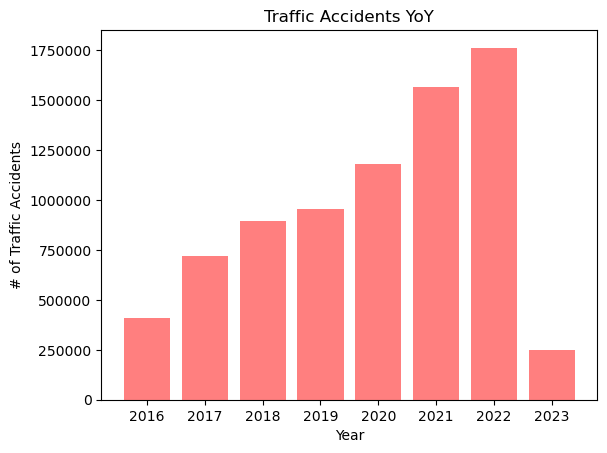

In [78]:
x_axis=reduced_traffic_gp.index.tolist()
y_axis = reduced_traffic_gp["State"].tolist()

plt.ticklabel_format(style='plain')
plt.bar(x_axis, y_axis,color='r',alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")
plt.show()

In [ ]:
city_traffic = reduced_traffic_df.groupby("City")
city_traffic_count = city_traffic.count().sort_values(by=["State"],ascending=False)
city_traffic_count.head(10)
#[city_traffic_count["State"] >=100000]


In [88]:
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"
json_url = requests.get(api_url).json()
print(api_url)

https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*&key=9adc74e4cfc4d4a300ce521d201d867bcab7e31a


In [89]:
print(json.dumps(json_url, indent=4))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
json_url[0]

['NAME', 'B01003_001E', 'state', 'place']

In [91]:
df = pd.DataFrame(json_url)
df

,0,1,2,3
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [92]:
df.columns=["City","Population","State(num)","Place(num)"]
df.head()

,City,Population,State(num),Place(num)
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484


In [93]:
drop = df.drop([0,0])
drop

,City,Population,State(num),Place(num)
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
5,"Akron town, Alabama",385,01,00676
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [94]:
test=drop["City"].str.split(',',expand=True)

In [95]:
test.columns=["City_1","State",""]
test

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [118]:
# df =pd.concat([drop,test],axis=1)
df1= df.query(["State"] !="Puerto Rico")
#df.drop(df.index["Puerto Rico"])
df1

TypeError: 'bool' object is not callable

In [119]:
df.dtypes

City          object
Population    object
State(num)    object
Place(num)    object
City          object
Population    object
State(num)    object
Place(num)    object
City_1        object
State         object
dtype: object

In [97]:
test = df.drop([""],axis=1)

In [98]:
census_clean_df = test.rename(columns={"City":"City_State","City_1":"City"})

In [99]:
census_clean_df.dtypes

City_State    object
Population    object
State(num)    object
Place(num)    object
City          object
State         object
dtype: object

In [ ]:
census_clean_df[census_clean_df["Population"]==231]